# Optimal mutation rate for global epistasis models

**ADD MORE DESCRIPTION**

## Setup for analysis

Import Python modules / packages:

In [1]:
import collections
import itertools
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Set parameters that define the simulated data.

**ADD MORE DESCRIPTION**

In [2]:
seed = 1  # random number seed
genelength = 300  # gene length in codons
variants_per_lib = 400 * genelength  # variants per library
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.01  # rate at which variant sequence mis-called
avgdepth_per_variant = 100  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.04  # random noise in selections
bottleneck = 10  # bottleneck from pre- to post-selection as multiple of variants_per_lib

# Try libraries with a variety of mutation rates, defined
# as average codon mutations per variant.
avgmuts_list = [1.0, 2.0, 3.0, 4.0]

Seed random number generator for reproducible output:

In [3]:
random.seed(seed)

Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html) as this gives a nice appearance for the plots:

In [6]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate library of variants
Simulate a library of codon variants of the gene.

Simulate wildtype gene sequence:

In [7]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 300 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGACAGGATTCTTCCCTGGATAAGATGTACCGCAGGGACGGGGGCCCGCGGCTTGTTCTTCCTCTCAACAAGGGGTTGGCACGAAGGCTGTTGGTTGAATCGATGCTTTTCGATCTACAAGACTTCAAAGTTTCATGCGTCTATCTTGAGCGCAATTCTGAGATACTGCTCCCCCCCGAAGCGGCCCGTAACATGAGGGATTCGTACTACTATATTTCCGGCACCAACAAAGTGATTACGGCGCCCACAAGCGAAAGGCAAGGTCGTCATCTAAACCCTCGCAGTACGTGCCTTATAGCATATAACAACAGAGGTAGCGGGGGCGACATCTTGTACCTTATCGCTCGAGATCATGCGAATCAGTTGTCTCAGTCGCAGTTAGTCCGCATTAAATCTAAGTATTTCGAGAGGTCGTTGGGGCTTCCTCCCATAGGCCGGAGTACGGGACAGCTGCATTCTTGCAACATACATTTTGTTCCAATAGGCTCCTGTCCATCTGGCCTCTTTATGGTAACCAGGTGGATAGTGGCATCCCCGCCACACTCGGCATTCTGCAGAGACACGAAGACATCGTACTCACCAGCCGTTCCTGAGATCACACAATGCGAGTGTCGTCAATACTCAAAAGGAACCACTTCTAAGATGTTTCGCACTAGGATGGTCACGTGGCCTTTGTGGCACATTCTCACGGCTAAGAAATTGCAGGCACGTCATAATTGGTTGTTGACGATCGCCTTGGACGGCGGAATTGAC


Generate a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
using
[simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable)
function, with different libraries for each mutation rate:

In [8]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={f"<m> = {avgmuts:.1f}": {'avgmuts': avgmuts,
                                                         'nvariants': variants_per_lib}
                               for avgmuts in avgmuts_list},
                seed=seed,
                )

Plot the number of amino-acid mutations per variant:

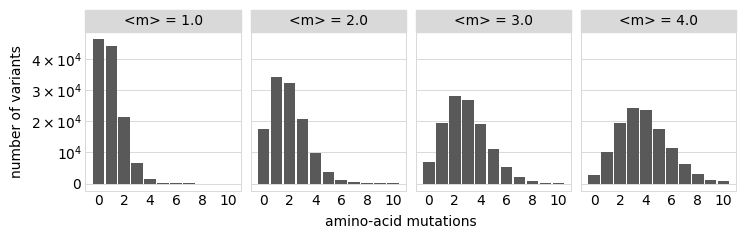

In [9]:
p = variants.plotNumMutsHistogram('aa',
                                  samples=None,
                                  libraries=variants.libraries,
                                  max_muts=round(2.5 * max(avgmuts_list)),
                                  widthscale=1.2,
                                  )
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Average number of codon mutations per variant:

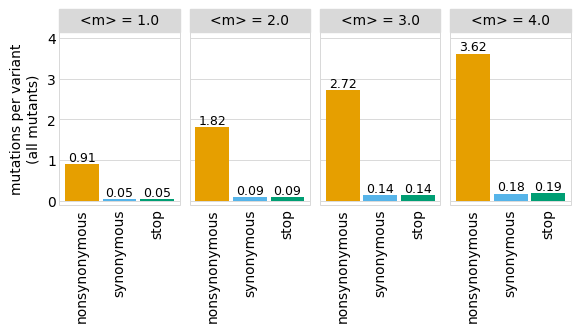

In [10]:
p = variants.plotNumCodonMutsByType(variant_type='all', samples=None,
                                    libraries=variants.libraries)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Examine how well amino-acid mutations are sampled in the library by looking at the
fraction
of mutations seen <= some number of times, making separate plots for single mutants and all mutants.
As expected, the libraries with lower mutation rates sample mutations somewhat better among **single**-mutant variants, but much worse among all variants.

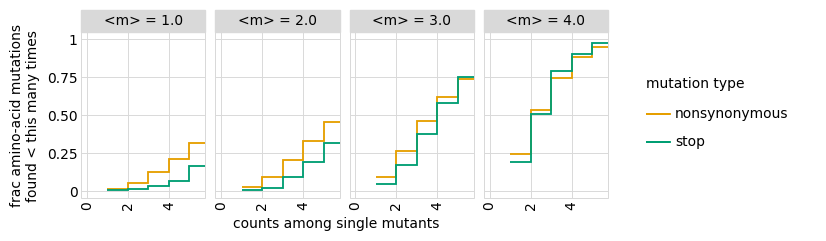

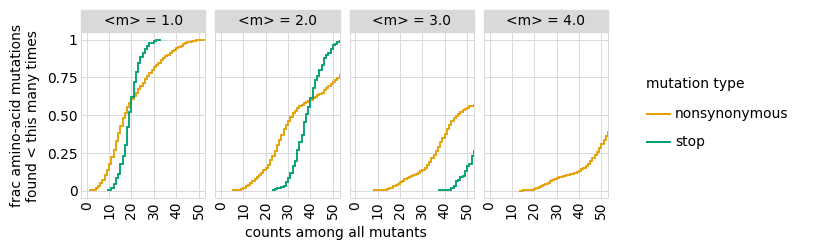

In [11]:
for variant_type in ['single', 'all']:
    p = variants.plotCumulMutCoverage(variant_type,
                                      mut_type='aa',
                                      samples=None,
                                      libraries=variants.libraries)
    _ = p.draw()

## Simulate counts for samples
Now we simulate the counts of each variant after selection.

First, we define a “phenotype” function using a
[SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator),
which follow the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) to define the phenotype in
two steps: an underlying latent phenotype that mutations affect additively, and
then an observed phenotype that is a non-linear
function of the latent phenotype.
The variants are then simulated according to their observed enrichments, which are the exponentials of the observed phenotypes:

In [12]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                                            geneseq,
                                            seed=seed,
                                            wt_latent=4,
                                            stop_effect=-10,
                                            norm_weights=((0.35, -1.25, 1.5),
                                                          (0.65, -5.5, 2.25))
                                            )

Plot the simulated relationship of the latent phenotype with the observed enrichment and phenotype, with a dashed
vertical line indicating the wildtype latent phenotype:

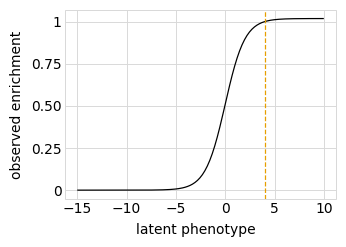

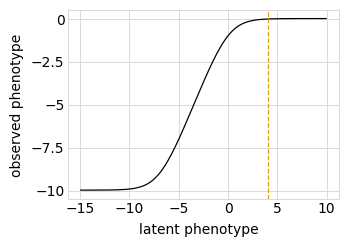

In [13]:
for value in ['enrichment', 'phenotype']:
    p = phenosimulator.plotLatentVsObserved(value)
    _ = p.draw()

Plot the latent phenotype, observed phenotype, and observed enrichment of all single amino-acid mutants, with a
dashed vertical line indicating the wildtype:

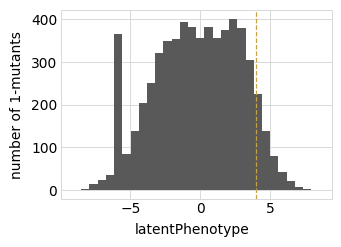

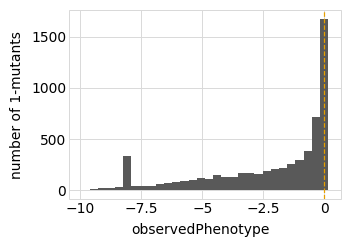

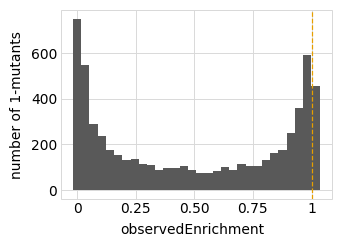

In [14]:
for value in ['latentPhenotype', 'observedPhenotype', 'observedEnrichment']:
    p = phenosimulator.plotMutsHistogram(value)
    _ = p.draw()

Now we use
[simulateSampleCounts](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulateSampleCounts)
to simulate counts of variants when selection on each variant is proportional to
its observed enrichment.
We simulate using the several different bottleneck sizes defined above:

In [15]:
counts = dms_variants.simulate.simulateSampleCounts(
        variants=variants,
        phenotype_func=phenosimulator.observedEnrichment,
        variant_error_rate=variant_error_rate,
        pre_sample={'total_count': variants_per_lib * avgdepth_per_variant,
                    'uniformity': lib_uniformity},
        pre_sample_name='pre-selection',
        post_samples={'post-selection': 
                          {'noise': noise,
                           'total_count': variants_per_lib * avgdepth_per_variant,
                           'bottleneck': variants_per_lib * bottleneck}
                      },
        seed=seed,
        )

Now add the simulated counts for each library /
sample to the
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable):

In [16]:
variants.add_sample_counts_df(counts)

Plot the number of counts for each variant in each sample. 
The horizontal
dashed line shows the total number of variants. 
The plot shows that all
variants are well-sampled in the pre-selection libraries, but that post-
selection some variants are sampled more or less.
This is expected since
selection will decrease and increase the frequency of variants:

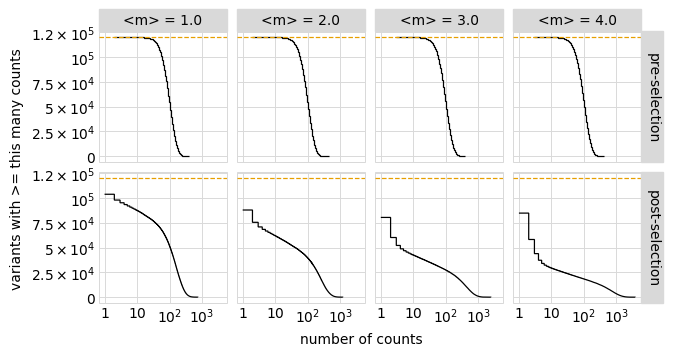

In [17]:
p = variants.plotCumulVariantCounts(libraries=variants.libraries)
_ = p.draw()

Distribution of the number of amino-acid mutations per variant in each sample.
As expected, mutations go down after selection:

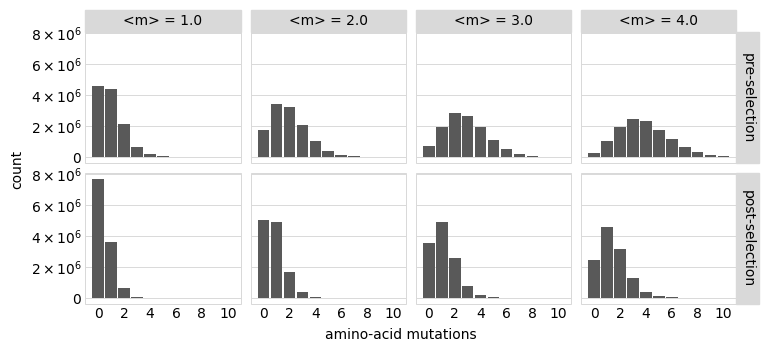

In [18]:
p = variants.plotNumMutsHistogram(mut_type='aa',
                                  libraries=variants.libraries,
                                  max_muts=round(2.5 * max(avgmuts_list)),
                                  widthscale=1.2)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Average number of mutations per variant:

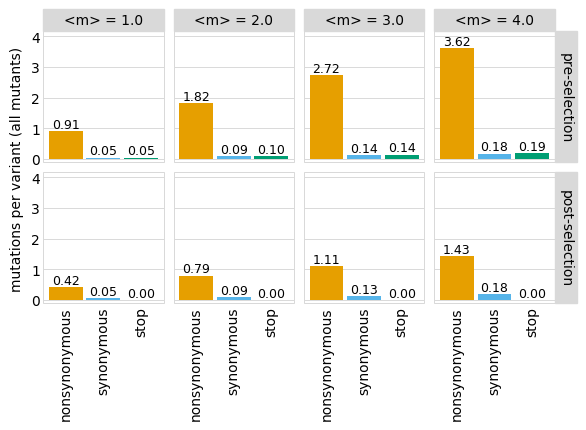

In [19]:
p = variants.plotNumCodonMutsByType(variant_type='all',
                                    libraries=variants.libraries)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Functional scores for variants
Use
[CodonVariantTable.func_scores](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores)
to calculates a functional score for each variant based on its change in
frequency from pre- to post-selection:

In [20]:
func_scores = variants.func_scores('pre-selection',
                                   libraries=variants.libraries)

Also calculate functional scores at the level of amino-acid variants:

In [21]:
aa_func_scores = variants.func_scores('pre-selection',
                                      by='aa_substitutions',
                                      syn_as_wt=True,
                                      libraries=variants.libraries)

Classify variants
by the “types” of mutations they
have using the
[CodonVariantTable.classifyVariants](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.classifyVariants):

In [22]:
func_scores = dms_variants.codonvarianttable.CodonVariantTable.classifyVariants(func_scores)

Plot the distributions of scores, coloring by the variant class.
As expected, there is more noise with a tighter bottleneck:

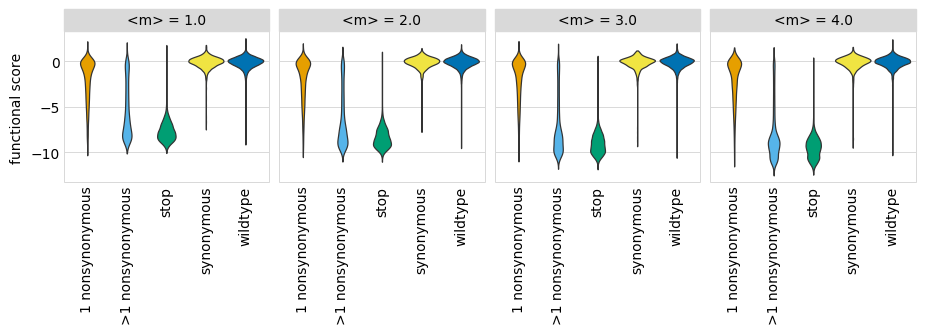

In [23]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_wrap('~ library', nrow=1) +
    theme(figure_size=(2.75 * len(variants.libraries), 2),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Fit global epistasis models
Now we fit global epistasis models.
We fit two different types of models each with two different ways of calculating the likelihood.

**UPDATE THIS DESCRIPTION**

The two types of models are:
 - [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) models, which model global epistasis in the way described in [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550).
 - [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) models, which assume mutations contribute additively to the functional scores.

The two ways of calculating the likelihood are:
 - [GaussianLikelihood](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.GaussianLikelihood): assumes deviations from model are normally distributed according to statistical estimates of errors in functional scores.
 - [CauchyLikelihood](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.GaussianLikelihood): a fat-tailed distribution that is less sensitive to measurements that have large deviations from the model.
 
See the [globalepistasis module documentation](https://jbloomlab.github.io/dms_variants/codonvariant_sim_data.html) for more details:

In [ ]:
# NBVAL_IGNORE_OUTPUT

models = {}  # store models, keyed by `(modeltype, likelihoodtype, library)`

for library, scores in func_scores.groupby('library', observed=True):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for epistasistype, liktype, Model in [
            ('global epistasis', 'Gaussian', 
             dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', 'Gaussian',
             dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy',
             dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy',
             dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} model with {liktype} likelihood to {library}...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()
        print(f"fitting took {time.time() - start:.1f} sec.")
        models[(epistasistype, liktype, library)] = model

Fitting global epistasis model with Gaussian likelihood to <m> = 1.0... fitting took 23.6 sec.
Fitting no epistasis model with Gaussian likelihood to <m> = 1.0... fitting took 2.5 sec.
Fitting global epistasis model with Cauchy likelihood to <m> = 1.0... fitting took 163.3 sec.
Fitting no epistasis model with Cauchy likelihood to <m> = 1.0... fitting took 9.8 sec.
Fitting global epistasis model with Gaussian likelihood to <m> = 2.0... fitting took 142.0 sec.
Fitting no epistasis model with Gaussian likelihood to <m> = 2.0... fitting took 1.4 sec.
Fitting global epistasis model with Cauchy likelihood to <m> = 2.0... fitting took 161.0 sec.
Fitting no epistasis model with Cauchy likelihood to <m> = 2.0... fitting took 9.0 sec.
Fitting global epistasis model with Gaussian likelihood to <m> = 3.0... fitting took 82.6 sec.
Fitting no epistasis model with Gaussian likelihood to <m> = 3.0... fitting took 1.4 sec.
Fitting global epistasis model with Cauchy likelihood to <m> = 3.0... 

Now we want to see which models fit the data better.
To do this, we get the log likelihood of each model along with the number of model parameters and use it to calculate the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).
Models with lower AIC are better.
We compute the $\Delta$AIC between the global epistasis model ([MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis)) and no-epistasis model ([NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis)): positive $\Delta$AIC values indicate that the global epistasis model is better.

Crucially, we can only compare models with likelihoods calculated in the same way: Gaussian likelihoods can be compared to each other, Cauchy likelilhoods can be compared to each other, but Gaussian and Cauchy likelihoods can **not** be compared.

Below we see that in all cases, the global epistasis model is better than the no-epistasis model:

In [ ]:
# NBVAL_IGNORE_OUTPUT

logliks_df = (
    pd.DataFrame.from_records(
            [(epistasistype, liktype, sample, model.nparams, model.loglik) for
             (epistasistype, liktype, sample), model in models.items()],
            columns=['epistasis_function', 'likelihood', 'sample',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .pivot_table(index=['sample', 'likelihood'],
                 values='AIC',
                 columns='epistasis_function',
                 )
    .assign(deltaAIC=lambda x: x['no epistasis'] - x['global epistasis'])
    )

logliks_df.round(1)

In [ ]:
# check to confirm the global epistasis model is better in all cases
assert (logliks_df['deltaAIC'] > 0).all()

Because the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis model is always better than the additive [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) model, below we just analyze the results from the global epistasis model.

First, we will examine how the model fits look on all the actual variants used to fit the model.
We use [AbstractEpistasis.phenotypes_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.phenotypes_df) to get a data frame of all the variants used to fit each global epistasis model along with their functional scores and the latent and observed phenotypes predicted by each model.
We also compute the measured and model-predicted enrichments for each variant (recall that the functional score / observed phenotype is the $\log_2$ of the enrichment as described [here](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores)):

In [ ]:
variants_df = pd.concat(
        [model.phenotypes_df
         .assign(sample=sample,
                 likelihood=liktype,
                 predicted_enrichment=lambda x: model.enrichments(
                                                 x['observed_phenotype']),
                 measured_enrichment=lambda x: 2**x['func_score'],
                 )
         for (epistasistype, liktype, sample), model in models.items()
         if epistasistype == 'global epistasis'],
        ignore_index=True, sort=False)

Below we plot the relationships between the observed and latent phenotype for each sample and likelihood-calculation method:

In [ ]:
p = (ggplot(variants_df, aes('latent_phenotype', 'observed_phenotype')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('sample ~ likelihood', scales='free') +
     theme(figure_size=(2 * variants_df['likelihood'].nunique(),
                        2 * variants_df['sample'].nunique()),
           )
     )
_ = p.draw()

## Model vs measurements vs truth for amino-acid variants
Because we simulated the variants, we can also use the [SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator) used in these simulations to get the **true** phenotype of each variant.
(Obviously in real non-simulated experiments the true phenotypes are unknown.)

We want to see if the model outperforms the experiments if look at the level of **amino-acid** variants (meaning we pool the counts for all variants with the same amino-acid substitutions together before calculating the functional scores).
Recall that above we already got such functional scores into the variable `aa_func_scores`:

First we get a data frame of measured functional scores (in the simulated experiment) calculated at the level of amino-acid variants (pooling all barcoded variants with the same amino-acid mutations):

In [ ]:
aa_variants_df = (
    aa_func_scores
    .rename(columns={'post_sample': 'sample'})
    [['sample', 'aa_substitutions', 'n_aa_substitutions', 'func_score']]
    .assign(measured_enrichment=lambda x: 2**x['func_score'])
    )

Now we add the model-predicted latent phenotype, observed phenotype, and enrichment for each amino-acid variant using the [AbstractEpistasis.add_phenotypes_to_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.add_phenotypes_to_df) method:

In [ ]:
df_list = []
for sample, df in aa_variants_df.groupby('sample', observed=True):
    for likelihood in ['Cauchy', 'Gaussian']:
        model = models[('global epistasis', likelihood, sample)]
        df_list.append(model.add_phenotypes_to_df(df)
                       .assign(predicted_enrichment=lambda x: 
                                  model.enrichments(x['observed_phenotype']),
                               likelihood=likelihood,
                           )
                   )
aa_variants_df = pd.concat(df_list, ignore_index=True, sort=False)

Now we add the "true" values from the simulator:

In [ ]:
aa_variants_df = (
    aa_variants_df
    .assign(
        true_latent_phenotype=lambda x: x['aa_substitutions'].map(
                phenosimulator.latentPhenotype),
        true_enrichment=lambda x: x['aa_substitutions'].map(
                phenosimulator.observedEnrichment),
        true_observed_phenotype=lambda x: x['aa_substitutions'].map(
                phenosimulator.observedPhenotype),
        )
    )

Now we calculate the correlations between the true enrichments from the simulations and the measured values and the ones predicted by the model.
We do this using enrichment rather than observed phenotype as we expect the observed phenotypes to be very noisy at the "low end" (since experiments lose the sensitivity to distinguish among bad and really-bad variants):

In [ ]:
# NBVAL_IGNORE_OUTPUT

enrichments_corr = (
    aa_variants_df
    .rename(columns={'predicted_enrichment': 'model prediction',
                     'measured_enrichment': 'measurement'})
    .melt(id_vars=['sample', 'likelihood', 'true_enrichment'],
          value_vars=['model prediction', 'measurement'],
          var_name='enrichment_type',
          value_name='enrichment',
          )
    .groupby(['sample', 'likelihood', 'enrichment_type'])
    .apply(lambda x: x['enrichment'].corr(x['true_enrichment']))
    .rename('correlation')
    .to_frame()
    .pivot_table(index=['sample', 'likelihood'],
                 values='correlation',
                 columns='enrichment_type')
    )

enrichments_corr.round(2)

In [ ]:
# this cell is just for testing purposes on the correlations above
assert scipy.allclose(
        enrichments_corr['model prediction'].values,
        scipy.array([0.991, 0.997, 0.989, 0.994, 0.933, 0.795]),
        atol=0.05), enrichments_corr['model prediction']

Above we see that the model predictions are always better than the actual measurements, and furthermore that when there is a very tight experimental bottleneck (lots of "noise") the Cauchy likelihood outperforms the Gaussian likelihood.

Below we plot the correlations between the model predictions and the true enrichments for each likelihood calculation method.
The plot shows that the Cauchy likelihood seems better than the Gaussian likelihood for the tight bottleneck, although it appears visually that for a loose bottleneck (relatively little experimental noise) the Guassian likelihood might be better:

In [ ]:
p = (ggplot(aa_variants_df, aes('true_enrichment', 'predicted_enrichment')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('sample ~ likelihood',  scales='free') +
     theme(figure_size=(2.5 * variants_df['likelihood'].nunique(),
                        2.5 * variants_df['sample'].nunique())
           )
     )

_ = p.draw()

## Model vs measurements vs truth for single mutants
Now we repeat the above analysis for just **single** amino-acid mutants.

First, get the single amino-acid mutant variants:

In [ ]:
single_aa_variants_df = (
    aa_variants_df
    .query('n_aa_substitutions == 1')
    .reset_index(drop=True)
    )

Tabulate how the measurements and model predictions compare to the true enrichments:

In [ ]:
# NBVAL_IGNORE_OUTPUT

enrichments_corr = (
    single_aa_variants_df
    .rename(columns={'predicted_enrichment': 'model prediction',
                     'measured_enrichment': 'measurement'})
    .melt(id_vars=['sample', 'likelihood', 'true_enrichment'],
          value_vars=['model prediction', 'measurement'],
          var_name='enrichment_type',
          value_name='enrichment',
          )
    .groupby(['sample', 'likelihood', 'enrichment_type'])
    .apply(lambda x: x['enrichment'].corr(x['true_enrichment']))
    .rename('correlation')
    .to_frame()
    .pivot_table(index=['sample', 'likelihood'],
                 values='correlation',
                 columns='enrichment_type')
    )

enrichments_corr.round(2)

In [ ]:
# this cell is just for testing purposes on the correlations above
# data frame for `nbval` testing.
assert scipy.allclose(
        enrichments_corr['model prediction'].values,
        scipy.array([0.996, 0.998, 0.995, 0.998, 0.934, 0.767]),
        atol=0.05), enrichments_corr['model prediction']

Once again, the model predictions outperform the measurements, and the Cauchy likelihood is noticeably better than the Gaussian likelihood for the tight bottleneck.

Plot the predictions for each likelihood-calculation method.
The plots below visually make clear that the Cauchy likelihood is better for the tight bottleneck (lots of noise).
It again visually appears that the Gaussian likelihood is a bit better for the loose bottleneck (very little noise):

In [ ]:
p = (ggplot(single_aa_variants_df, aes('true_enrichment', 'predicted_enrichment')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('sample ~ likelihood',  scales='free') +
     theme(figure_size=(2.5 * variants_df['likelihood'].nunique(),
                        2.5 * variants_df['sample'].nunique())
           )
     )

_ = p.draw()